# Probabilities in Bầu Cua Cá Cọp, a Vietnamese New Year Game

<center><img src="bau_cua_ca_cop.jpg"/></center>

In this game, there are 6 spots you can place money on non-exclusively and 3 dice. Each round, we roll all dice simultaneously.

If AT LEAST one of the dice lands on a spot where you've placed money, you win double the money. If two dice land on your chosen spot, you triple your money, and if you're so lucky that all three dice land on your spot, you’ll quadruple your money. 

**In this notebook**, we'll calculate the expected value of placing one dollar on a single spot and verify theory through numerical simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Part 1: Betting a single dollar

### Defining game utility functions

The probability of winning is  $1-P($no dice land on your spot$) = 1 - (5/6)^3 = 42.13\%$

We'll define a function that can return dice outcomes for $N$ rolls of 3 dice.

In [2]:
roll = lambda n: np.random.randint(low=0, high=6, size=(n, 3))

Now we'll create a function to determining the payouts based on dice rolls. We'll assume that the player always bets on index 0.

In [3]:
# Mapping between number of matching dice and amount you get back
payout_dict = {
    0: 0,
    1: 2,
    2: 3,
    3: 4
}

def calc_payout(dice_rolls):
    """Determine payouts from a set of dice rolls."""
    num_matches = np.sum(dice_rolls == 0, axis=1)
    payouts = np.zeros(len(num_matches), dtype=int)

    # Calculate the payout for individual dice rolls
    for i, dice_match in enumerate(num_matches):
        payouts[i] = payout_dict[dice_match]
        
    return payouts

### Simulation
Now let's roll this a ton of times and see what happens.

In [122]:
# Roll the dice a million times
n_trials = 1000000
dice_rolls = roll(n_trials)

# Calculate payouts
payouts = calc_payout(dice_rolls)

### Results

First we will visualize the probability for each payout. 

In [5]:
# Count number of occurrences for each outcome
win_amounts, counts = np.unique(payouts, return_counts=True)

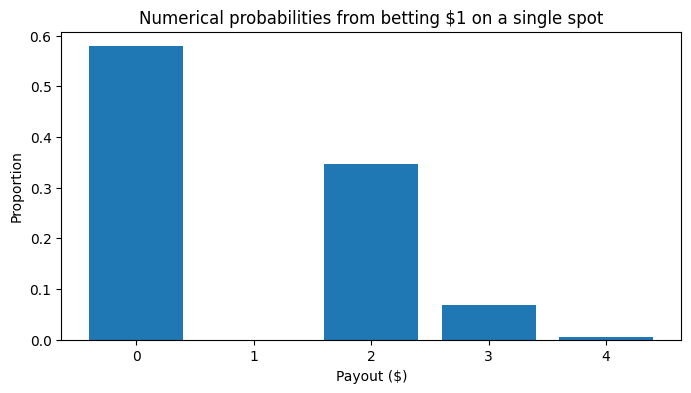

In [6]:
# Plot probabilities
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(win_amounts, height=counts/n_trials)
_= ax.set(xlabel="Payout ($)", ylabel="Proportion", 
          title="Numerical probabilities from betting $1 on a single spot")

And now let's see what our expected value is!

In [8]:
print(f"Expected value: {np.mean(payouts)}")

Expected value: 0.921017


So on average, when you bet a dollar, you'll expect to gain back 92 cents, which are pretty good odds for this simple betting strategy. Over the long run, you'd still expect to lose, but not by much.

## Part 2: Betting on multiple positions

What if you wanted to place bets on multiple spots? I'm not smart enough to calculate the theoretical probability, so I'll just numerically estimate the expected values.

We'll adapt our previous `calc_payout()` function to account for multiple betting positions. Instead of computing the expected value of the total dollars you'll receive back, we'll calculate the expected _net profit_ for a clearer idea how much money you make back, independent of how much money you bet in the first place.

In [9]:
def calc_payout_multiple(dice_rolls, bet_spots=1):
    """Determine payouts from a set of dice rolls."""
    payouts = np.zeros(len(dice_rolls), dtype=int)

    # Iterate over each spot you bet on
    for k in np.arange(bet_spots):
        num_matches = np.sum(dice_rolls == k, axis=1)
    
        # Calculate the payout for individual dice rolls
        for i, dice_match in enumerate(num_matches):

            # Here we ADD to the payouts array instead of merely setting it
            # because we must add in payouts from previous wins as we
            # continually iterate through different betting positions
            payouts[i] += payout_dict[dice_match]

    # Subtract the amount bet
    payouts -= bet_spots
            
    return payouts

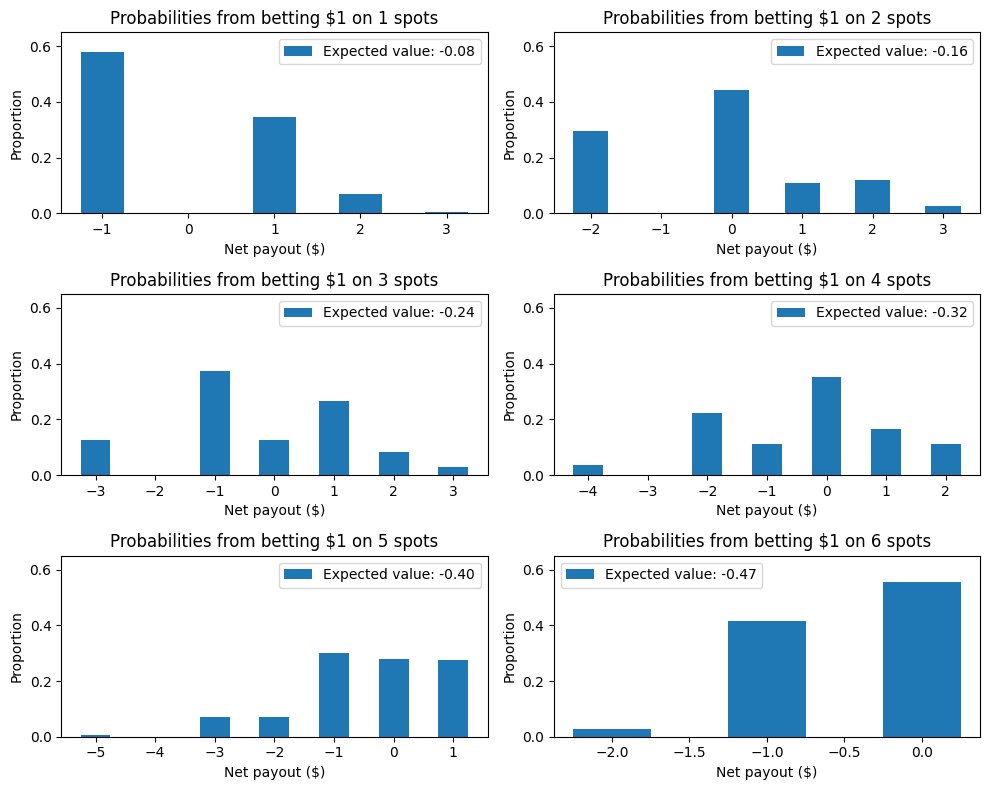

In [11]:
fig_multiple_bets, ax_multiple_bets = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))

for i, bet_spots in enumerate(np.arange(1, 7)):
    ax = ax_multiple_bets.flatten()[i]
    
    # Calculate net winnings for increasing number of spots covered
    payouts = calc_payout_multiple(dice_rolls, bet_spots=bet_spots)
    win_amounts, counts = np.unique(payouts, return_counts=True)

    # Plot probability and expected net profits
    ax.bar(win_amounts, 
           height=counts/n_trials, width=0.5,
           label=f"Expected value: {np.mean(payouts):.2f}")
    _= ax.set(xlabel="Net payout ($)", ylabel="Proportion", ylim=[0, 0.65],
              title=f"Probabilities from betting $1 on {bet_spots} spots")
    ax.legend()

fig_multiple_bets.tight_layout()

From this, we can see that it's actually worse to place money on multiple positions than betting a single dollar.

## Part 3: Martingale Betting

Sticking with betting on only one position, we'll test out the [Martingale betting strategy](https://www.investopedia.com/terms/m/martingalesystem.asp). The crux of this strategy is simple: on a win, bet the same amount next round, and on a loss, double the bet. This means that as the game progresses, the betting amount scales exponentially (unless you happen to win every single round).

We assume that the player has an unlimited bankroll, i.e. if they run out of money, they'll just keep putting more money in to play.

In [156]:
def martingale_episode(n_rounds):
    """Simulate an episode of betting with the Martingale strategy."""
    # Track the number of rounds, the dollar amount at each round, and the
    # overall winnings for every round
    money = 1
    winnings_arr = np.zeros(n_rounds, dtype=int)

    # Simulate all rolls and win factors ahead of time for speed
    dice_rolls = roll(n_rounds)
    payouts = calc_payout_multiple(dice_rolls, bet_spots=1)

    # Iterate through rolls and update winnings after each round
    bet_amount = 1

    for r in np.arange(n_rounds):
        # Check payout if we won this round
        won_money = payouts[r] > 0

        # Reset betting amount after a win, but double the bet on a loss
        if won_money:
            money += bet_amount * payouts[r]
            bet_amount = 1
        else:
            money -= bet_amount
            bet_amount *= 2

        winnings_arr[r] = money
    
    return winnings_arr

Now we'll simulate 10 rounds of betting with the Martingale strategy a million times and find out the average outcome.

In [157]:
# Simulate 10 rounds of betting over many trials
n_martingale_bets = 10
episode_results = np.zeros((n_trials, n_martingale_bets), dtype=int)

for ep in range(n_trials):
    episode_results[ep] = martingale_episode(n_martingale_bets)

Martingale average outcome after each round: [ 0.921866  0.797801  0.621839  0.388621  0.080369 -0.322629 -0.807766
 -1.356924 -2.089461 -2.950438]


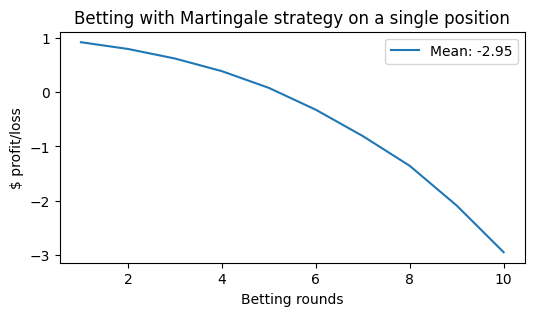

In [158]:
# Compute average outcome for each round
mean_martingale = np.mean(episode_results, axis=0)
print(f"Martingale average outcome after each round: {mean_martingale}")

# Plot average profits
fig_martingale, ax_martingale = plt.subplots(figsize=(6, 3))
ax_martingale.plot(np.arange(1, n_martingale_bets + 1), mean_martingale, 
                   label=f"Mean: {mean_martingale[-1]:.2f}")

ax_martingale.set(xlabel="Betting rounds", ylabel="$ profit/loss",
          title=f"Betting with Martingale strategy on a single position")

_= ax_martingale.legend()

Based on the simulations, you should never adopt the Martingale strategy unless you'd love to lose a lot of money! In that case, I'd recommend donating to the house directly to save yourself some time.